In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from collections import Counter
from dateutil.parser import parse
from collections import OrderedDict
from datetime import datetime, date, timedelta
from IPython.display import display # Allows the use of display() for DataFrames
from scipy import stats

# Pretty display for notebooks
%matplotlib inline

# Load the dataset
data = pd.read_csv("../data/ny_times/google/news_features.csv")

# Success - Display the first record
display(data.head(n=1))
display(data.describe())

,id,pub_date,headline_senti,summary_senti,headline_summary_senti,lead_paragraph_senti,keyword_in_headline,keyword_in_summary,keyword_org_rank_alt,section_name,type_of_material,print_page,word_count,trade_date,price,percent_change
0,4fd247fa8eb7c8105d7e44de,2004-08-20T00:00:00Z,0.0,0.6597,0.6597,0.796,1,1,1.0,Opinion,Editorial,22,687,2004-08-20,50.178635,1.009999


,headline_senti,summary_senti,headline_summary_senti,lead_paragraph_senti,keyword_in_headline,keyword_in_summary,keyword_org_rank_alt,print_page,word_count,price,percent_change
count,6615.000000,6615.000000,6615.000000,6615.000000,6615.000000,6615.000000,6615.000000,6615.000000,6615.000000,6615.000000,6615.000000
mean,0.018357,0.147223,0.155743,0.146824,0.495540,0.780045,0.302208,2.409373,551.250340,302.107360,0.103071
std,0.240212,0.413199,0.459004,0.417176,0.500018,0.414247,0.385741,6.075418,507.655017,118.470830,2.108167
min,-0.891000,-0.985000,-0.985000,-0.999600,0.000000,0.000000,0.000000,0.000000,0.000000,50.148830,-11.563501
25%,0.000000,0.000000,-0.051600,0.000000,0.000000,1.000000,0.000000,0.000000,221.000000,229.748215,-0.893498
50%,0.000000,0.025800,0.128000,0.000000,0.000000,1.000000,0.000000,0.000000,438.000000,279.561707,0.088970
75%,0.000000,0.475400,0.525700,0.440400,1.000000,1.000000,0.500000,2.000000,788.500000,329.139267,1.114258
max,0.868900,0.995200,0.995200,0.999600,1.000000,1.000000,1.000000,138.000000,17686.000000,669.200012,18.102495


682.0:2117.0
1739.0:6615.0


,Date,Open,Change,HasNews
2793,2015-09-23,622.049988,-0.789476,0
2794,2015-09-24,616.640015,-0.869701,1
2795,2015-09-25,629.770020,2.129282,0
2796,2015-09-28,610.340027,-3.085252,1
2797,2015-09-29,597.280029,-2.139791,1


,Open,Change,HasNews
count,2217.000000,2217.000000,2217.0
mean,308.657854,0.113445,1.0
std,131.447025,2.130005,0.0
min,50.148830,-11.563501,1.0
25%,226.029892,-0.888882,1.0
50%,276.690399,0.067047,1.0
75%,356.536072,1.064621,1.0
max,669.200012,18.102495,1.0


,Open,Change,HasNews
count,581.000000,580.000000,581.0
mean,283.162996,0.096664,0.0
std,170.908794,1.780060,0.0
min,49.274517,-9.102519,0.0
25%,147.590073,-0.822347,0.0
50%,236.988617,0.034529,0.0
75%,425.373352,0.994422,0.0
max,661.270020,6.998006,0.0


(-11.577297457007496, 18.116291751368273)

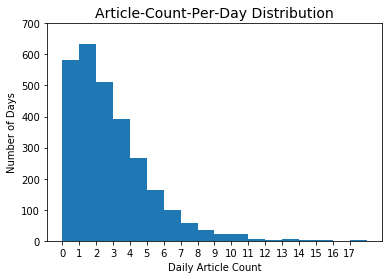

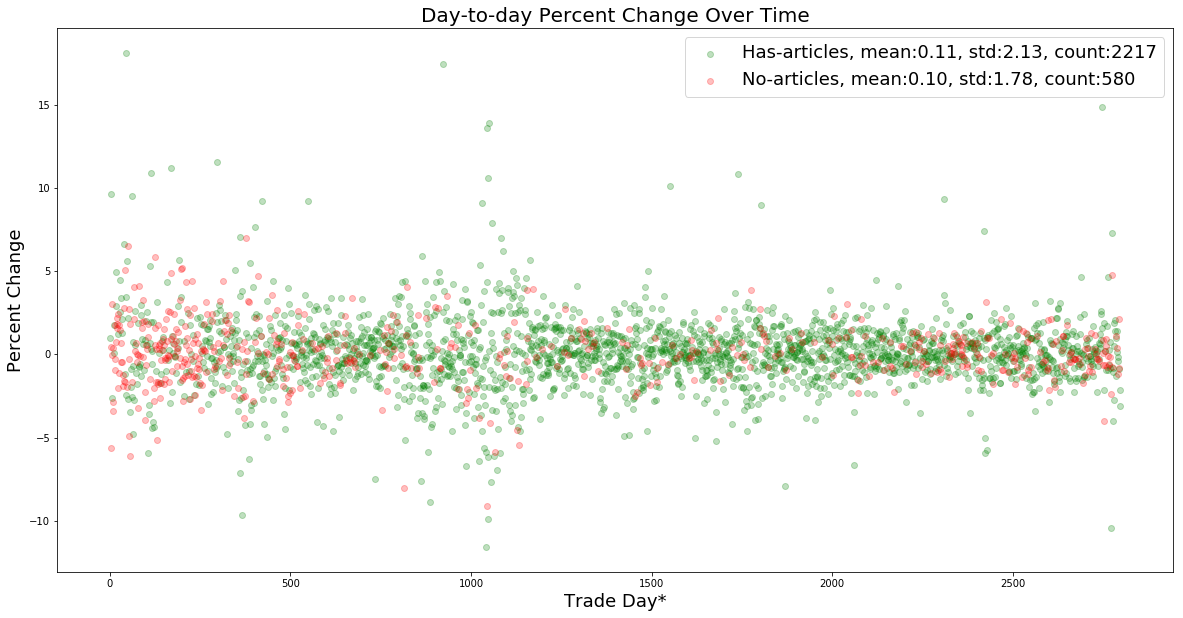

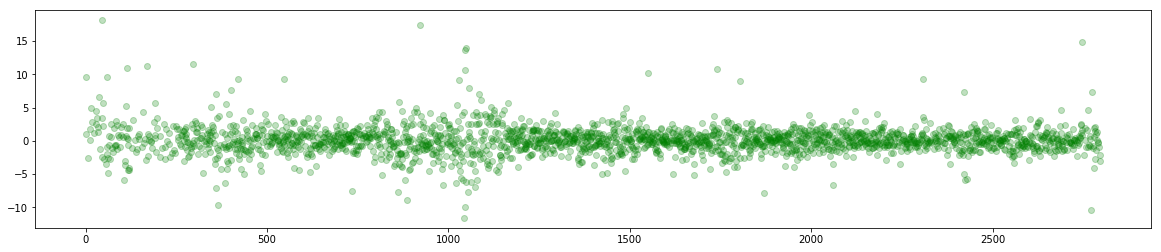

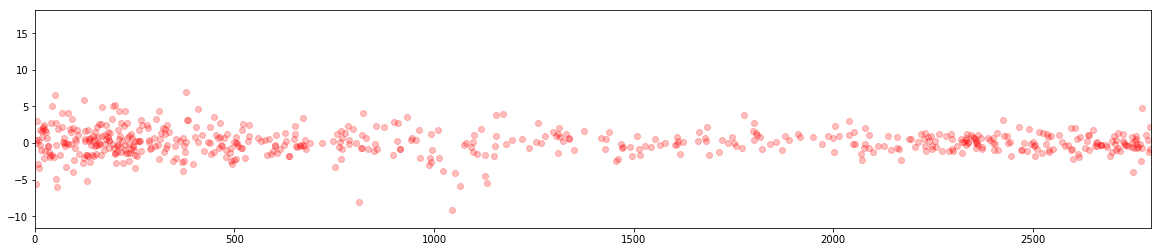

In [2]:
# article count by trade date
article_count = Counter(data['trade_date'])

# find trade dates with no articles
trade_data = pd.read_csv("../data/GOOG.csv")
trade_data = trade_data[['Date', 'Open']]
valid_range = [i for i in trade_data.index if parse(trade_data.Date[i]).date()==date(2015,9,30)\
                 or parse(trade_data.Date[i]).date()==date(2004,8,19)] # data is in chronological order, so just store endpoints
trade_data = trade_data[valid_range[0]:valid_range[1]]
trade_dates_0 = [d for d in trade_data.Date if d not in article_count]

# update counter to include trade dates with no articles
for d in trade_dates_0:
    article_count[d]=0

# print(article_count)

# trade dates with more than 10 articles
# date = [i[0] for i in article_count.iteritems() if i[1]>10 ]
# print(date)


# -----------------------------------------------------------------------------------------
# plot distribution of article-count-per-day
# calculate basic related stats

# plot histogram: frequency of article count
fig, ax = plt.subplots()
article_freq = article_count.values() # number of articles per day
# print(range(min(article_freq), max(article_freq) + 1, 1))
values, bins, _= ax.hist(article_freq, bins=range(min(article_freq), max(article_freq) + 2, 1))

ax.set_title("Article-Count-Per-Day Distribution", fontsize = 14)
ax.set_xlabel("Daily Article Count")
ax.set_ylabel("Number of Days")
ax.set_ylim((0, 700))
ax.set_xticks(range(min(article_freq), max(article_freq) + 1, 1))
ax.set_xticklabels(range(min(article_freq), max(article_freq) + 1, 1))

# number of trade days with 3 articles or less
days_3rless = sum(values[0:4])

# number of trade days with more than 3 articles
days_4rmore = sum(values[4:])

print("{0}:{1}").format(days_4rmore, days_3rless)

# approx. fraction of articles comprising the top 3 articles of each day
articles_total = sum(np.multiply(bins[:-1],values))

# number of articles to be filtered out if only top 3 articles of each day is used
articles_remove = sum(np.multiply(bins[4:-1],values[4:])) - 3*sum(values[4:])

# fraction of articles to be removed
print("{0}:{1}").format(articles_remove, articles_total)


# --------------------------------------------------------------------------
# plot day-to-day percent changes for trade days with no associated articles
# vs. those that do

# add daily percent change column to dataframe
percent_change = [(trade_data.Open[i] - trade_data.Open[i-1])/trade_data.Open[i-1]*100\
                  if i>0 else None for i in range(0, trade_data.Open.size)]
trade_data['Change']= pd.Series(percent_change, index=trade_data.index)

# print(percent_change)

# add column that tags whether the trade day has associated articles or not
tags = [0 if d in trade_dates_0 else 1 for d in trade_data.Date]
trade_data['HasNews'] = pd.Series(tags, index=trade_data.index)
# print(tags)
display(trade_data.tail(n=5))

# create subsets of 'hasNews' vs 'noNews'
trade_data_hasNews = trade_data[trade_data.HasNews==1]
trade_data_noNews = trade_data[trade_data.HasNews==0]
stats_hasNews=trade_data_hasNews.describe()
stats_noNews=trade_data_noNews.describe()
display(stats_hasNews)
display(stats_noNews)

# plot the 2 subsets together
# include basic stats in legend
fig1, ax1 = plt.subplots(figsize=(20,10))
ax1.scatter(trade_data_hasNews.index, trade_data_hasNews.Change, c='green', alpha=0.25,\
           label= "Has-articles, mean:{0:.2f}, std:{1:.2f}, count:{2:.0f}".format\
            (stats_hasNews.Change['mean'], stats_hasNews.Change['std'], \
             stats_hasNews.Change['count']))
ax1.scatter(trade_data_noNews.index, trade_data_noNews.Change, c='red', alpha=0.25,\
           label= "No-articles, mean:{0:.2f}, std:{1:.2f}, count:{2:.0f}".format\
            (stats_noNews.Change['mean'], stats_noNews.Change['std'],\
             stats_noNews.Change['count']))
ax1.legend(fontsize=18)
ax1.set_title("Day-to-day Percent Change Over Time", fontsize = 20)
ax1.set_xlabel("Trade Day*", fontsize=18) # Where '0' corresponds to the first trade day in the data series
ax1.set_ylabel("Percent Change",fontsize=18)

# plot the 'hasNews' subset alone
fig3, ax3 = plt.subplots(figsize=(20,4))
ax3.scatter(trade_data_hasNews.index, trade_data_hasNews.Change, c='green', alpha=0.25)

# plot the 'noNews' subset alone
fig2, ax2 = plt.subplots(figsize=(20,4))
ax2.scatter(trade_data_noNews.index, trade_data_noNews.Change, c='red', alpha=0.25)
ax2.set_xlim((ax3.dataLim.x0,ax3.dataLim.x1))
ax2.set_ylim((ax3.dataLim.y0,ax3.dataLim.y1))

# Thoughts on main scatter plot:
# day-to-day changes >= 7% mostly corresponds to 'has-news' days. 
# Fluctuations on 'no-news' days can correspond to: (1) events not captured by nyt 
# (2) carry-over effects of news from previous days
# *Note the visual bias inherent in this plot as the ratio of no-news to has-news is ~6:28 -> ~1:5 


In [3]:
# categorical features 'section_name' and 'type_of_materials' would result in a lot of 'new features' after 1-hot encoding
# Here, we consolidate the minority categories into a single category to reduce dimensionality, plus remove articles 
# which belong to obviously irrelevant categories

# remove articles with the given feature values
def remove_articles(df, feature_name, feature_values):
    count_init = len(df.index)
    for v in feature_values:
        df = df[df[feature_name] != v]
    print "articles removed: {}".format(count_init - len(df.index))
    return df

# change feature values not in a 'top-categories' list to 'Other' 
def merge_categories(df, feature_name, top_categories):
    data_copy = df.copy(deep=False)
    for v in top_categories:
        data_copy = data_copy[data_copy[feature_name] != v]
    df.loc[data_copy.index, feature_name] = 'Other'
    print "articles with {} changed to 'Other': {}".format(feature_name, len(data_copy.index))

    
# 1. SECTION_NAME
###################################
article_count_init = len(data.index)
section_count = Counter(data['section_name'])

# todo: do bar graph

sections_top8 = ['Technology', 'Business Day', 'Business', 'Technology; Business', 'Opinion', 'U.S.', 'World']
sections_articles_remove = ['Corrections; New York and Region', 'Paid Death Notices', 'Corrections', 'false', 
'Crosswords/Games', 'Open', 'Corrections; Business', 'Dining and Wine; Style; Corrections',
 'Crosswords & Games', 'Obituaries', 'Corrections; U.S.']
data = remove_articles(data, 'section_name', sections_articles_remove)


# section_count = Counter(data['section_name'])
# # print(sum(list(section_count.values())))
# print "articles removed: " + str( article_count_init - len(data.index))

# merge sections not in the top 8 into a single section called 'Other'
merge_categories(data, 'section_name', sections_top8) 
section_count = Counter(data['section_name'])
print(section_count)
print "articles total: {}".format(sum(list(section_count.values())))


# 2. TYPE_OF_MATERIAL
###################################
type_count = Counter(data['type_of_material'])
type_count_tuples = [(key, value) for key,value in type_count.iteritems()]
type_count_tuples.sort(reverse=True, key=lambda x: x[1])
# for t in type_count_tuples:
#     print "{} \t {}".format(t[0], t[1])

types_top10 = ['Blog', 'News', 'Summary', 'Question', 'Video', 'Op-Ed', 
               'Interactive Feature', 'Letter', 'Brief', 'Editorial']
types_articles_remove = ['Correction', 'Obituary', 'Biography'] #, 'nan'] #TODO: ?'nan' is actually some other rep?

data = remove_articles(data, 'type_of_material', types_articles_remove)
merge_categories(data, 'type_of_material', types_top10)
type_count = Counter(data['type_of_material'])
print(type_count)

#NEXT: bar charts of distributions

articles removed: 86
articles with section_name changed to 'Other': 1063
Counter({'Technology': 2992, 'Business Day': 1205, 'Other': 1063, 'Business': 554, 'Technology; Business': 282, 'Opinion': 236, 'U.S.': 103, 'World': 94})
articles total: 6529
articles removed: 33
articles with type_of_material changed to 'Other': 98
Counter({'Blog': 3478, 'News': 2248, 'Summary': 257, 'Other': 98, 'Question': 82, 'Video': 76, 'Op-Ed': 69, 'Interactive Feature': 58, 'Letter': 55, 'Brief': 39, 'Editorial': 36})


In [4]:
# feature pre-processing
features = data.drop(['id', 'pub_date', 'trade_date', 'price'], axis=1)
features = pd.get_dummies(features) #one-hot encode categorical features
display(features.head(n=5))

,headline_senti,summary_senti,headline_summary_senti,lead_paragraph_senti,keyword_in_headline,keyword_in_summary,keyword_org_rank_alt,print_page,word_count,percent_change,...,type_of_material_Brief,type_of_material_Editorial,type_of_material_Interactive Feature,type_of_material_Letter,type_of_material_News,type_of_material_Op-Ed,type_of_material_Other,type_of_material_Question,type_of_material_Summary,type_of_material_Video
0,0.0000,0.6597,0.6597,0.7960,1,1,1.0,22,687,1.009999,...,0,1,0,0,0,0,0,0,0,0
1,-0.1779,0.8934,0.8750,-0.2960,0,1,1.0,4,566,1.009999,...,0,0,0,0,1,0,0,0,0,0
2,0.0000,0.4767,0.4767,-0.3612,1,1,1.0,1,1543,1.009999,...,0,0,0,0,1,0,0,0,0,0
3,0.0000,-0.0772,-0.0772,0.7845,0,1,0.0,1,111,1.009999,...,0,0,0,0,0,0,0,0,1,0
4,0.0000,0.2263,0.2263,0.2960,1,1,0.0,2,74,9.642612,...,0,0,0,0,1,0,0,0,0,0


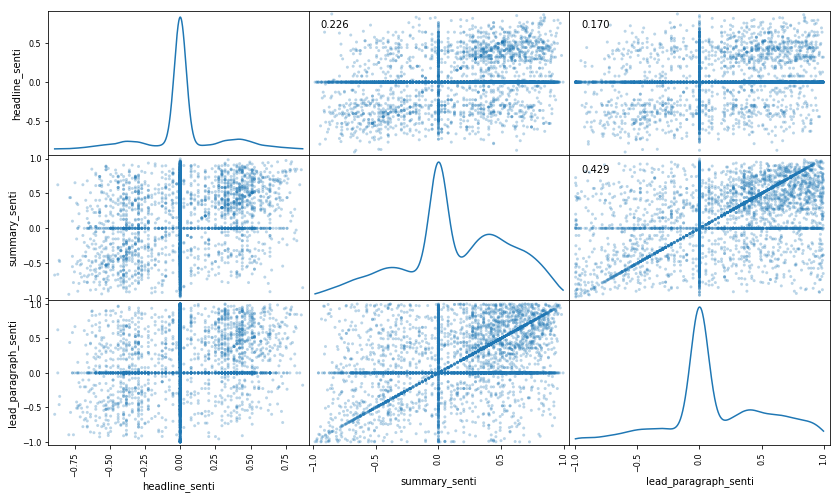

In [8]:
sentiment_features = features[['headline_senti','summary_senti','lead_paragraph_senti']] #'headline_summary_senti',
axes = pd.plotting.scatter_matrix(sentiment_features, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
corr = sentiment_features.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.1, 0.9), xycoords='axes fraction', ha='center', va='center')
plt.show() #a subset of articles showing strong correlation between sentiment scores for leading paragraph and summary

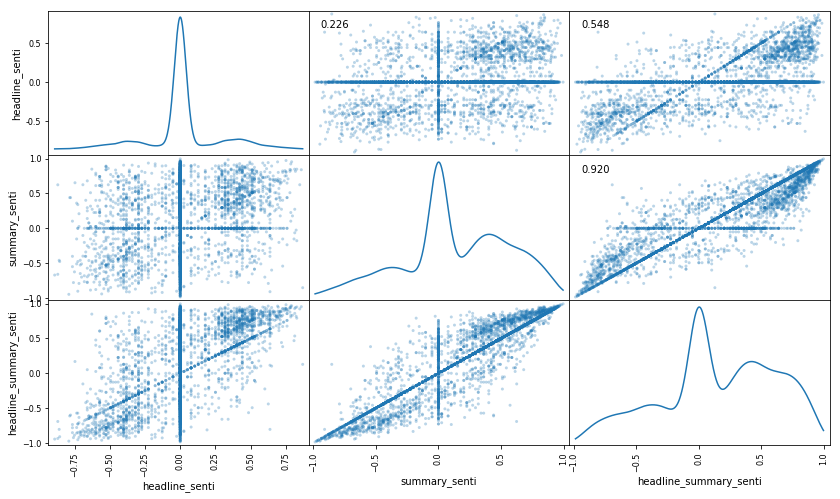

In [9]:
sentiment_features_1 = features[['headline_senti','summary_senti','headline_summary_senti']]
axes_1 = pd.plotting.scatter_matrix(sentiment_features_1, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
corr = sentiment_features_1.corr().as_matrix()
for i, j in zip(*plt.np.triu_indices_from(axes_1, k=1)):
    axes_1[i, j].annotate("%.3f" %corr[i,j], (0.1, 0.9), xycoords='axes fraction', ha='center', va='center')
plt.show() 
# plot shows strong correlation between sentiment scores for headline_summary and summary -> Vader sentiment scores 
# are at least self-consistent, the correlation is ~ self-correlation of summary sentiments, as headline sentiments
# are neutral on the whole
# Looks likely that the summary is the only one that matters here, the positive skew makes sense compared to the more neutral headline
# todo: compare this with the distribution of stock price changes

